In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from oblique_decision_tree import OC1

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier as DT

In [7]:
iris = datasets.load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Single-tree evaluation.

In [13]:
OC1_accuracy_lst, DT_accuracy_lst = [], []
OC1_height_lst, DT_height_lst = [], []
for _ in range(5):
    kf = KFold(n_splits=5, shuffle=True)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        data_train = np.concatenate([X_train, y_train], axis=1)
        data_test = np.concatenate([X_test, y_test], axis=1)

        oc1 = OC1()
        oc1.fit(data_train)
        OC1_accuracy_lst.append(accuracy_score(y_true=y_test, y_pred=oc1.predict(data_test)))
        OC1_height_lst.append(oc1.get_depth())

        dt = DT(criterion='gini', splitter='best', random_state=42)
        dt.fit(X_train, y_train)
        DT_accuracy_lst.append(accuracy_score(y_true=y_test, y_pred=dt.predict(X_test)))
        DT_height_lst.append(dt.get_depth())

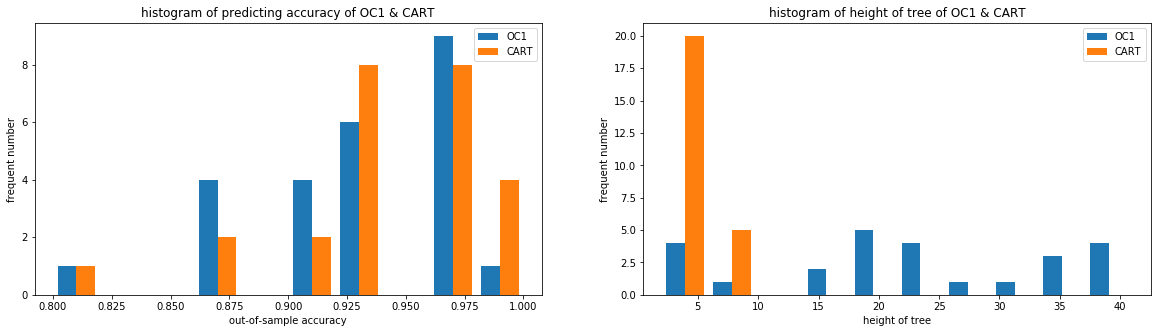

In [29]:
accuracy_df = pd.DataFrame(np.array([OC1_accuracy_lst, DT_accuracy_lst]).T, columns=['OC1', 'CART'])
height_df = pd.DataFrame(np.array([OC1_height_lst, DT_height_lst]).T, columns=['OC1', 'CART'])

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist([OC1_accuracy_lst, DT_accuracy_lst], label=['OC1', 'CART'])
plt.xlabel('out-of-sample accuracy')
plt.ylabel('frequent number')
plt.title('histogram of predicting accuracy of OC1 & CART')
plt.legend()

plt.subplot(122)
plt.hist([OC1_height_lst, DT_height_lst], label=['OC1', 'CART'])
plt.xlabel('height of tree')
plt.ylabel('frequent number')
plt.title('histogram of height of tree of OC1 & CART')
plt.legend()
plt.show()

# Forest evaluation.

In [80]:
tree_num = 50
OC1_accuracy_lst, CART_accuracy_lst = [], []

for train_size in np.arange(0.1, 1, 0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    data_train = np.concatenate([X_train, y_train], axis=1)
    data_test = np.concatenate([X_test, y_test], axis=1)
    
    OC1_prediction_mat = np.zeros((len(y_test), tree_num))
    CART_prediction_mat = np.zeros((len(y_test), tree_num))

    for i in range(tree_num):
        oc1 = OC1()
        oc1.fit(data_train, perturbation=10)
        OC1_prediction_mat[:, i] = oc1.predict(data_test)

        dt = DT(criterion='gini', splitter='best')
        dt.fit(X_train, y_train)
        CART_prediction_mat[:, i] = dt.predict(X_test)
    
    OC1_prediction = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=OC1_prediction_mat.astype(int))
    CART_prediction = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=CART_prediction_mat.astype(int))
    
    OC1_accuracy_lst.append(accuracy_score(y_pred=OC1_prediction, y_true=y_test))
    CART_accuracy_lst.append(accuracy_score(y_pred=CART_prediction, y_true=y_test))

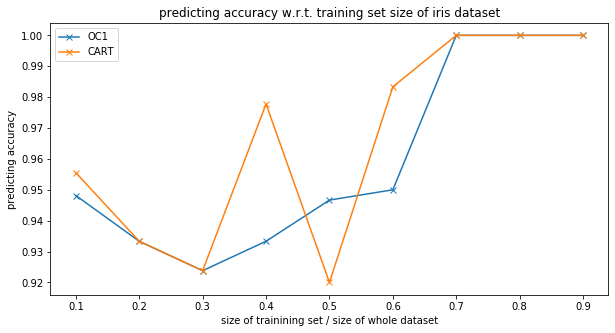

In [83]:
forest_res_df = pd.DataFrame(np.array([OC1_accuracy_lst, CART_accuracy_lst]).T, index=np.arange(0.1, 1, 0.1), columns=['OC1', 'CART'])
ax = forest_res_df.plot(figsize=(10, 5), marker='x', title='predicting accuracy w.r.t. training set size of iris dataset')
ax.set_xlabel('size of trainining set / size of whole dataset')
ax.set_ylabel('predicting accuracy')
plt.show()